# Batch normalization tutorial

## Reference:

Ioffe, S., & Szegedy, C. (2015, June). Batch normalization: Accelerating deep network training by reducing internal covariate shift. In International conference on machine learning (pp. 448-456).

When during training we update the weights of a given layer with index $r$, the output distribution of each layer after $r$ changes as well. Small changes to the weights can get amplified through the network as it gets deeper. This is called *internal covariate shift*, and this constantly shifting distribution complicates training, see the reference above.

It is common practice to normalize the inputs and outputs. In essense, batch normalization also normalizes the output of *hidden* layers such that their mean output is close to 0 and the output standard deviation close to 1, yielding a more stable distribution during training.

***Normalization***

Batch normalization does so by making normalization part of the architecture. Consider the figure below, which shows how batch normalization is applied to the $i$-th neuron of layer $r$. The linear preactivation value $v_r^{(i,k)}$ is computed as usual from the output of the previous layer:

\begin{align*}
v_r^{(i,k)} = \sum_j W_r^{(j, i)}h_{r-1}^{(j,k)}
\end{align*}

where $j$ sums over all neurons of the previous layer. Here $W_r^{(j, i)}$ is the weight of the $r$-th layer, connecting neuron $j$ of layer $r-1$ to neuron $i$ of layer $r$. During training we randomly select a mini-batch of training data at every back propagation step. The index $k$ counts over the different values in the mini batch, $k=1,\cdots,K$, where $K$ is the batch size (e.g. 32 or 64).

Without batch normlization, the $K$ outputs of the neuron would be $\Phi(v_r^{(i,k)})$, where $\Phi$ is the chosen (non-linear) activation function, applied elementwise over the mini batch. Here there is an additional batch normalization (BN) node (see figure), which normalizes the preactivation values. It does so by first normalizing $v_r^{(i,k)}$

\begin{align*}
\hat{v}_r^{(i,k)} = \frac{v_r^{(i,k)} - \mu_r^{(i)}}{\sigma_r^{(i)}}
\end{align*}

Here $\mu_r^{(i)}$ and $\sigma_r^{(i)}$ are the mean and standard deviation computed over each mini batch used in training. While $\hat{v}_r^{(i,k)}$ is normalized, the output based on $\hat{v}_r^{(i,k)}$ (i.e. $h_r^{(i,k)}=\Phi(\hat{v}_r^{(i,k)})$) will not be able to represent all possible values of the activation function. For this reason the normalized preactivation value that is used in the end is given by

\begin{align*}
a_r^{(i, k)} = \gamma_r^{(i)}\hat{v}_r^{(i,k)} + \beta_r^{(i)}.
\end{align*}

Here, $\gamma_r^{(i)}$ and $\beta_r^{(i)}$ are tunable constants that are learned during back propagation.

![](bn.png)

***Back propagation***

The gradient of the loss function $L$ with respect to the output of the $i$-th neuron ($h_{r}^{(i,k)}$) is available from standard back propagation. It "lives" at the non-linear activation part of the neuron, see figure above. Now we have to propagate the loss through the BN node, before we can compute the gradient loss with respect to the weights connected to the $i$-th neuron. Via the chain rule we first compute

\begin{align*}
\boxed{
\frac{\partial L}{\partial a_r^{(i, k)}} = \frac{\partial L}{\partial h_r^{(i, k)}}\frac{\partial h_r^{(i, k)}}{\partial a_r^{(i, k)}} = \frac{\partial L}{\partial h_r^{(i, k)}}\Phi'(a_r^{(i, k)})}
\end{align*}

Where $\Phi'$ is the derivative of the activation function, which is known analytically. The independent variables of $v_r^{(i,k)}$ are $\hat{v}_r^{(i, k)}$, $\mu_r^{(i)}$ and the batch variance $(\sigma_r^{(i)})^2$. Hence, via the chain rule:

\begin{align*}
\frac{\partial L}{\partial v_r^{(i, k)}} &= 
\frac{\partial L}{\partial \hat{v}_r^{(i, k)}}\frac{\partial \hat{v}_r^{(i, k)}}{\partial v_r^{(i, k)}}
+
\frac{\partial L}{\partial \mu_r^{(i)}}\frac{\partial \mu_r^{(i)}}{\partial v_r^{(i, k)}}
+
\frac{\partial L}{\partial (\sigma_r^{(i)})^2}\frac{\partial (\sigma_r^{(i)})^2}{\partial v_r^{(i, k)}}
\\
&=
\boxed{
\frac{\gamma_r^{(i)}}{\sigma_r^{(i)}}\frac{\partial L}{\partial a_r^{(i, k)}}
+
\frac{1}{K}\frac{\partial L}{\partial \mu_r^{(i)}}
+
\frac{2}{K}(v_r^{(i,k)} - \mu_r^{(i)})\frac{\partial L}{\partial (\sigma_r^{(i)})^2}}
\end{align*}

Hence, we also need to compute the loss gradients with respect to the two samples moments. We start with the 2nd moment $(\sigma_r^{(i)})^2$. The two remaining independent variables are $\mu_r^{(i)}$ and $\hat{v}_r^{(i, k)}$, such that:

\begin{align*}
\frac{\partial L}{\partial (\sigma_r^{(i)})^2}  = 
\frac{\partial L}{\partial \mu_r^{(i)}}\frac{\partial \mu_r^{(i)}}{\partial (\sigma_r^{(i)})^2} +
\sum_k \frac{\partial L}{\partial \hat{v}_r^{(i,k)}}\frac{\partial \hat{v}_r^{(i,k)}}{\partial (\sigma_r^{(i)})^2} = \sum_k \frac{\partial L}{\partial \hat{v}_r^{(i,k)}}\frac{\partial \hat{v}_r^{(i,k)}}{\partial (\sigma_r^{(i)})^2}
\end{align*}

The first terms is zero since the 1st moment does not depend upon the 2nd moment. The above can be written as

\begin{align*}\boxed{
\frac{\partial L}{\partial (\sigma_r^{(i)})^2}  = -\frac{\gamma_r^{(i)}}{2(\sigma_r^{(i)})^3}\sum_k(v_r^{(i, k)} - \mu_r^{(i)})\frac{\partial L}{\partial a_r^{(i, k)}}}
\end{align*}

Finally;

\begin{align*}
\frac{\partial L}{\partial \mu_r^{(i)}}  &= 
\frac{\partial L}{\partial (\sigma_r^{(i)})^2}\frac{\partial (\sigma_r^{(i)})^2}{\partial \mu_r^{(i)}} +
\sum_k \frac{\partial L}{\partial \hat{v}_r^{(i,k)}}\frac{\partial \hat{v}_r^{(i,k)}}{\partial \mu_r^{(i)}} \\
&=
\boxed{
\frac{\gamma_r^{(i)}}{(\sigma_r^{(i)})^3}\left[\sum_k(v_r^{(i, k)} - \mu_r^{(i)})\frac{\partial L}{\partial a_r^{(i, k)}}\right]\left[\frac{1}{K}\sum_k (v_r^{(i, k)} - \mu_r^{(i)})\right] - \frac{\gamma_r^{(i)}}{\sigma_r^{(i)}}\sum_k\frac{\partial L}{\partial a_r^{(i, k)}}}
\end{align*}

Now everything is in place to calucate $\partial L/\partial v_r^{(i, k)}$, which in turn is used to finally obtain the loss gradient with respect to the weights, averaged over the mini batch:

\begin{align*}
\boxed{
\frac{\partial L}{\partial W_r^{(j, i)}} = \frac{1}{K}\sum_k \frac{\partial L}{\partial v_r^{(i, k)}}\frac{\partial v_r^{(i, k)}}{\partial W_r^{(j, i)}} = \frac{1}{K}\sum_k \frac{\partial L}{\partial v_r^{(i, k)}}h_{r-1}^{(j, k)}}
\end{align*}

As previously mentioned, $\gamma_r^{(i)}$ and $\beta_r^{(i)}$ are also learned via back propagation, i.e. they are updated through: 

\begin{align*}
\frac{\partial L}{\partial \gamma_r^{(i)}} &= \sum_k \frac{\partial L}{\partial a_r^{(i, k)}}\frac{\partial a_r^{(i, k)}}{\partial \gamma_r^{(i)}} = \boxed{\sum_k \frac{\partial L}{\partial a_r^{(i, k)}}\hat{v}_r^{(i, k)}}
%
\\
\frac{\partial L}{\partial \beta_r^{(i)}} &= \sum_k \frac{\partial L}{\partial a_r^{(i, k)}}\frac{\partial a_r^{(i, k)}}{\partial \beta_r^{(i)}} = \boxed{\sum_k \frac{\partial L}{\partial a_r^{(i, k)}}}
\end{align*}

***Prediction***

During training, $\mu_r^{(i)}$, $\sigma_r^{(i)}$ are computed from mini-batch samples. In addition, a running average of both moments, denoted by $\bar{\mu}_r^{(i)}$, $\bar{\sigma}_r^{(i)}$ is computed during training:

\begin{align*}
\bar\mu_r^{(i)} &= \bar\mu_r^{(i)} m  + \mu_r^{(i)}  (1 - m) \\
\bar\sigma_r^{(i)} &= \bar\sigma_r^{(i)} m  + \sigma_r^{(i)}(1-m)
\end{align*}

Here, $m$ is the momentum parameter, a typical value is 0.99. In the prediction phase the running averages are used for normalization.

***Demonstration***

Now we will demonstrate the effect of Batch Normalization on training a vanilla Generative Adversarial Network (GAN). The architecture is shown below, we refer to the GAN tutorial (`/tutorials/GAN.ipynb`) for details.

![](GAN.png)

Uncomment the lines below if you need to install EasySurrogate, or emnist (the training data used here).

In [1]:
#!pip install easysurrogate
#!pip install emnist

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import easysurrogate as es
import pandas as pd
from tqdm import tqdm
from IPython import display

from emnist import list_datasets, extract_training_samples

Here we define the discriminator network $D$. The output layer has sigmoid activation which makes sure D always predicts a value between 0 and 1. The learning rate (`alpha`), momentum parameter for the loss gradient(`beta1`) and activation of the hidden layers (`activation`) are set to common values used for training GANs.

We will scale the data to lie within $[-1, 1]$ and the output is already scaled to lie within $[0,1]$, so there is no need to standardize the training data (`standardize_X = standardize_y = False`). 

We do not apply batch normalization to the Discriminator.

In [3]:
def define_discriminator(X_train, n_layers, n_neurons, batch_size = 32,
                         alpha = 0.0002, beta1 = 0.5):
    """
    Set up the Discriminator.

    Parameters
    ----------
    X_train : array (n_train, n_in)
        The training data.
    n_layers : int
        The number of layers.
    n_neurons : int or list
        The number of neurons for the hidden layers.
    batch_size : int, optional
        The size of 1 mini batch. The default is 32.
    alpha : float, optional
        The learning rate. The default is 0.0002.
    beta1 : float, optional
        Momentum parameter (coefficient moving average of loss gradient).
        The default is 0.5.

    Returns
    -------
    D : ANN
        The discriminator network.

    """

    D = es.methods.ANN(X_train[0].reshape([1, -1]), np.array([1]),
                       n_layers=n_layers,
                       n_neurons=n_neurons,
                       activation='parametric_relu', relu_a = 0.2,
                       activation_out='sigmoid',
                       bias = True,
                       loss='binary_cross_entropy',
                       batch_size=batch_size,
                       alpha=alpha, beta1=0.5,
                       standardize_X=False, standardize_y = False)
    return D

We define the generator $G$ in a similar fashion. Since the output will be a data sample where each pixel lies within $[-1, 1]$, we select tanh as output activation.

Batch normalization can be turned on by the `batch_norm` flag.

In [4]:
def define_generator(n_layers, n_neurons, n_out, n_latent, batch_size = 32,
                     alpha = 0.0002, beta1 = 0.5, batch_norm=False):
    """
    Set up the generator.

    Parameters
    ----------
    n_layers : int
        The number of layers.
    n_neurons : int or list
        The number of neurons for the hidden layers.
    n_out : int
        The number of output neurons (=size data sample).
    n_latent : int
        The number of input neurons (=size latent space).
    batch_size : int, optional
        The size of 1 mini batch. The default is 32.
    alpha : float, optional
        The learning rate. The default is 0.0002.
    beta1 : float, optional
        Momentum parameter (coefficient moving average of loss gradient).
        The default is 0.5.

    Returns
    -------
    G : ANN
        The generator network.

    """

    G = es.methods.ANN(np.random.randn(1, n_latent), None,
                       n_layers = n_layers, n_neurons = n_neurons,
                       n_out = n_out,
                       activation = 'parametric_relu', relu_a = 0.2,
                       activation_out='tanh', bias = True,
                       batch_size=batch_size, batch_norm=batch_norm,
                       alpha = alpha, beta1 = beta1,
                       standardize_X=False, standardize_y = False)

    return G

This subroutine randomly draws `n_samples` samples from the training data. It is used during training of D. As all samples are real, the corresponding labels $y_i$ are all equal to 1.

In [5]:
def generate_real_samples(X_train, n_samples):
    """
    Randomly select n_samples from the training data.

    Parameters
    ----------
    X_train : array (n_train, n_in)
        The training data.
    n_samples : int
        The number of samples to select.

    Returns
    -------
    real : array (n_samples, n_in)
        n_samples randomly selected training samples of size n_in.
    y_i : array (n_samples, 1)
        Corresponding labels for binary_cross_entropy loss (all 1's).

    """
    
    rand_idx = np.random.randint(0, X_train.shape[0], n_samples)
    real = X_train[rand_idx]
    # labels for cross entropy, all ones as all samples come from data
    y_i = np.ones([n_samples, 1])

    return real, y_i

This subroutine randomly draws `n_samples` samples from G. It is used during training of D and G. As all samples are fake, the corresponding labels $y_i$ are all equal to 0.

In [6]:
def generate_fake_samples(G, n_samples):
    """
    Generate n_samples fake samples.

    Parameters
    ----------
    G : ANN
        The ganerator.
    n_samples : int
        The number of samples to generate.

    Returns
    -------
    fake : array (n_samples, n_in)
        n_samples randomly generated fake samples of size n_in.
    y_i : int 
        Corresponding labels for binary_cross_entropy loss (all 0's).

    """
    # sample the random latent space
    z = latent_space(G.n_in, n_samples)
    fake = G.feed_forward(z, n_samples).T
    # labels for cross entropy, all zeros as all samples are fake
    y_i = np.zeros([n_samples, 1])

    return fake, y_i

This subroutine just returns a random sample from the latent space ${\bf z}\sim p({\bf z})$.

In [7]:
def latent_space(n_latent, n_samples):
    """
    Sample the latent space

    Parameters
    ----------
    n_latent : int
        The dimension of the latent space.
    n_samples : int
        The number of samples.

    Returns
    -------
    array (n_samples, n_latent)
        n_samples x n_latent draws from iid standard Gaussians.

    """

    return np.random.randn(n_samples, n_latent)

This subroutine trains the GAN. During each mini batch:

* D is trained first on a set of real and fake samples. 
* Then, G is trained using fake samples only, and by "lying" to D by setting $y_i=1$. 
* This loss is then propagated through D by calling `D.batch(G_i, y_i.T)`. We do not call `D.update_weights` as we do not want the weights of D to be updated with this false loss gradient. 
* By calling `G.back_prop(y_i)` we propagate the loss fruther from the input layer of D though all layers of G, and subsequently we do update the weights of G.


To show the effect of batch normalization, some on-the-fly plotting is done by calling the `draw` function every `n_draw` mini-batch iterations. This will plot some random samples from the Generator, but more importantly here, it will plot confidence intervals on the output of a neuron from the last layer of the Generator.

***Important***: Note that we have to toggle a training flag via `set_batch_norm_training_flag`. If True, $\mu_r^{(i)}$,$\sigma_r^{(i)}$ are computed over the mini batches. If False, the moving averages are used.

In [8]:
def train(n_batch, batch_size, G, D, X_train, n_draw = 1000):
    """
    Train a GAN.

    Parameters
    ----------
    n_batch : int
        The total number of mini batch iterations
    batch_size : int
        The size of 1 mini batch.
    G : ANN
        The generator.
    D : ANN
        The discriminator.
    X_train : array (n_train, n_in)
        The training data.
    n_draw : int
        Draw some information on screen every n_draw iterations.

    Returns
    -------
    None.

    """

    # half the batch size
    half_batch = int(batch_size / 2)
    # the learning rate
    alpha = G.alpha

    # set the batch normalization training flag
    G.set_batch_norm_training_flag(True)
    
    for n in tqdm(range(n_batch)):

        # generate half_batch real samples
        real, real_labels = generate_real_samples(X_train, half_batch)

        # generate half_batch fake samples
        fake, fake_labels = generate_fake_samples(G, half_batch)

        # merge real and fake samples
        X_i = np.append(real, fake, axis = 0)
        y_i = np.append(real_labels, fake_labels, axis = 0)

        # run the mini batch to compute the loss gradient
        D.batch(X_i, y_i.T)

        # update the weights of the Discriminator
        D.update_weights(alpha)

        # generate fake samples, do not return the true labels
        G_i, _ = generate_fake_samples(G, batch_size)            
        
        # create false labels, to 'lie' to the Discriminator
        y_i = np.ones([batch_size, 1])

        # feed fake samples to D, telling D they come from the data,
        # batch computes loss gradient but does not update weights of D
        D.batch(G_i, y_i.T)

        # back propagates loss from D through G
        G.back_prop(y_i)
        
        # update the weights of the Generator
        G.update_weights(alpha)

        # store the mini batch values of the 1st neuron from the 2nd hidden layer
        activation_G.append(G.layers[2].h[0,:])

        # show pobabilities during training
        if np.mod(n, n_draw) == 0: p = draw(G, fig)

    # set the batch normalization training flag
    G.set_batch_norm_training_flag(False)

This does as the doc string suggests.

In [9]:
def draw(G, fig):
    """
    Draw stuff on screen while training.

    Returns
    -------
    None.

    """

    plt.clf()
    display.clear_output(wait=True) # required to make plot update work in Jupyter notebook

    gs = GridSpec(5, 10, figure=fig)

    # plot probabilities
    ax = fig.add_subplot(gs[:, 0:5], ylabel='confidence intervals neuron output', xlabel='batch')
    activation = np.array(activation_G).T
    lower, upper = analysis.get_confidence_intervals(activation)
    ax.plot(lower, '--b', label='95% CI')    
    ax.plot(upper, '--b')
    ax.plot(np.mean(activation, axis=0), label='mean')
    
    plt.legend()

    # plot 25 random G samples
    I, J = 5, 5
    idx = 0
    for i in range(I):
        for j in range(J):
            ax = fig.add_subplot(gs[i, j + 5], xticks=[], yticks=[])       
            idx += 1
            im = G.feed_forward(latent_space(G.n_in, 1), batch_size=1)
            ax.imshow(im.reshape([28, 28]))
    plt.tight_layout()
    
    display.display(fig) # required to make plot update work in Jupyter notebook
    

Call this to draw random data samples.

In [10]:
def draw_data_points():
    """
    plot 4 random data points
    
    """
    idx = np.random.randint(0, X_train.shape[0], size = 4)
    fig_ = plt.figure()
    for count, i in enumerate(idx):
        ax = fig_.add_subplot(2, 2, count + 1, xticks=[], yticks=[])    
        ax.imshow(X_train[i].reshape([image_size, image_size]))
    plt.tight_layout()

The following data sets are available from the emnist package:

In [11]:
list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

We will use the standard 28 x 28 MNIST hand-written number images as training data. If you also would like to include letters, select the `'balanced'` data set instead. As mentioned we will scale the data to lie in $[-1, 1]$.

In [12]:
image_size = 28 
X_train, _ = extract_training_samples('mnist')
# Scale data to [-1, 1] (= range tanh activation)
X_train = X_train / 255 * 2 - 1
X_train = X_train.reshape(-1, image_size ** 2)

Plot some training data samples ${\bf x}$.

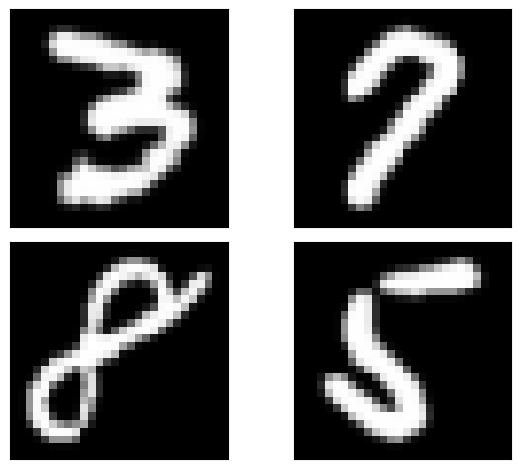

In [13]:
plt.rcParams['image.cmap'] = 'Greys_r'
draw_data_points()

Set some parameters:

In [14]:
# number of desired epochs
n_epochs = 100
# number of training samples
n_train = X_train.shape[0]
# size of 1 mini batch
batch_size = 64
# number of mini batch iterations for 1 epoch
epoch = int(n_train / batch_size)
# number of mini batch iterations for n_epoch epochs
n_iter = epoch * n_epochs
# dimension latent space (= dimension of z)
n_latent = 100
# size of 1 training sample
n_out = image_size**2

Define G and D using the subroutines above, **without** batch normalization.

In [15]:
G = define_generator(n_layers = 3, 
                     n_neurons = [256, 512, 1024], 
                     n_out = n_out,
                     n_latent = n_latent,
                     batch_size = batch_size,
                     batch_norm=False)

D = define_discriminator(X_train, 
                         n_layers = 2,
                         n_neurons = [512, 256],
                         batch_size = batch_size)

Neural net parameters
Number of layers = 3
Number of features = 100
Loss function = squared
Number of neurons per hidden layer = [256, 512, 1024]
Number of output neurons = 784
Activation = ['linear', 'parametric_relu', 'parametric_relu', 'tanh']
This neural network has 559632 weights.
Neural net parameters
Number of layers = 2
Number of features = 784
Loss function = binary_cross_entropy
Number of neurons per hidden layer = [512, 256]
Number of output neurons = 1
Activation = ['linear', 'parametric_relu', 'sigmoid']
This neural network has 402433 weights.


### Important:

Since G is trained with the loss gradient coming from D, the output layer of G must be connected to the input later of D. Set `layer_rp1` ($\mathrm{layer}_{r+1}$) attribute of G's output layer to D's input layer. Once this is done the loss gradient from D will flow to G when calling `G.back_prop` in the `train` subroutine.

In [16]:
G.layers[-1].layer_rp1 = D.layers[0]

This is the list in which the mini-batch values of a neuron from the last hidden layer are stored. Values are computed in the `train` subroutine, and the confidence intervals are plotted in `draw`.

In [17]:
# list for storing activation of a single neuron
activation_G = []
# analysis object to compute the confidence intervals
analysis = es.analysis.BaseAnalysis()

Train the GAN **without** batch normalization. The confidence intervals of the selected neuron should show significant variantion over the mini batches.

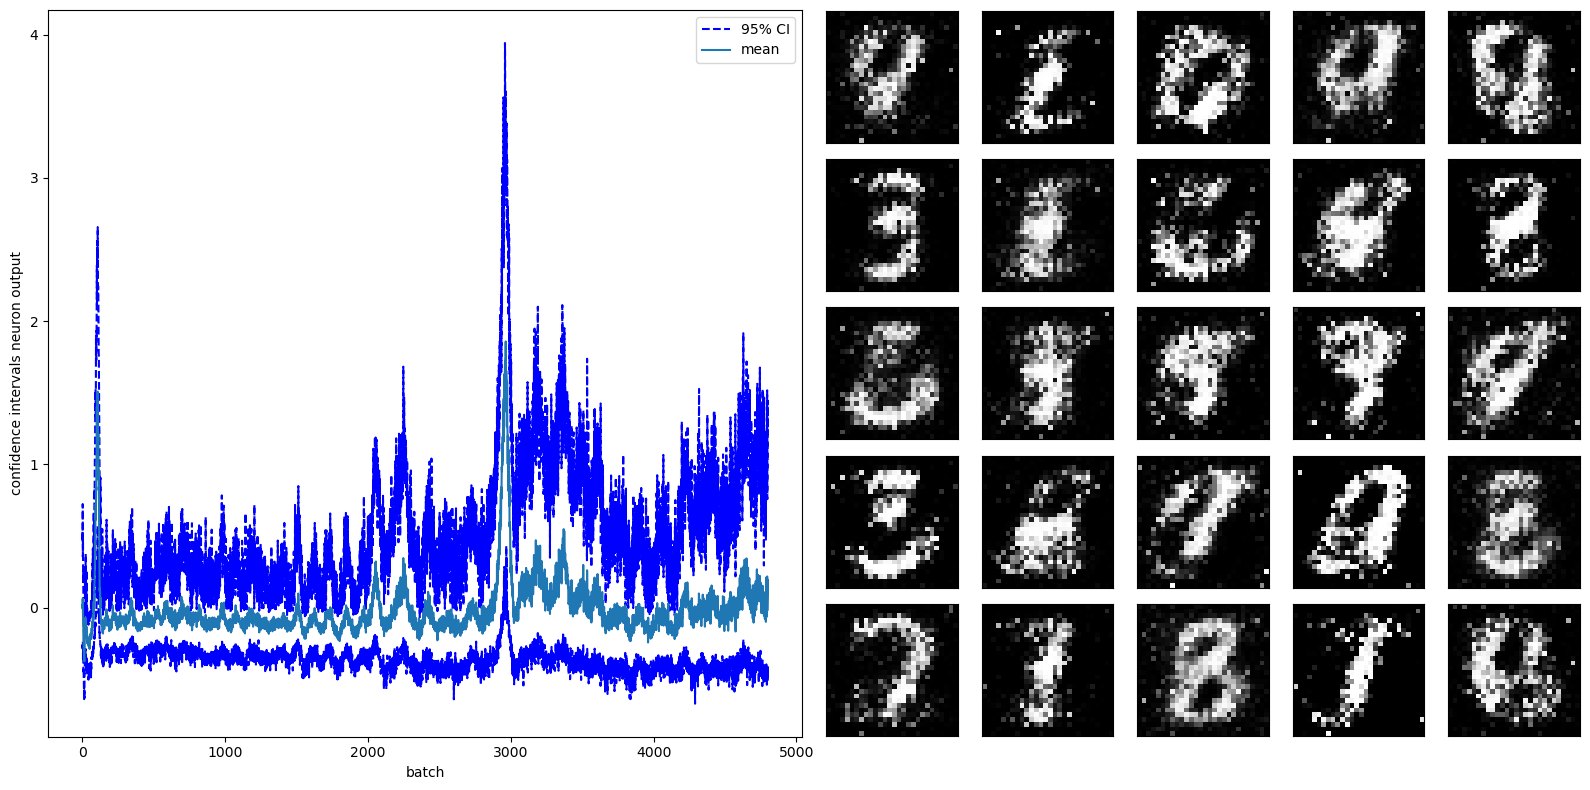

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [05:37<00:00, 14.83it/s]


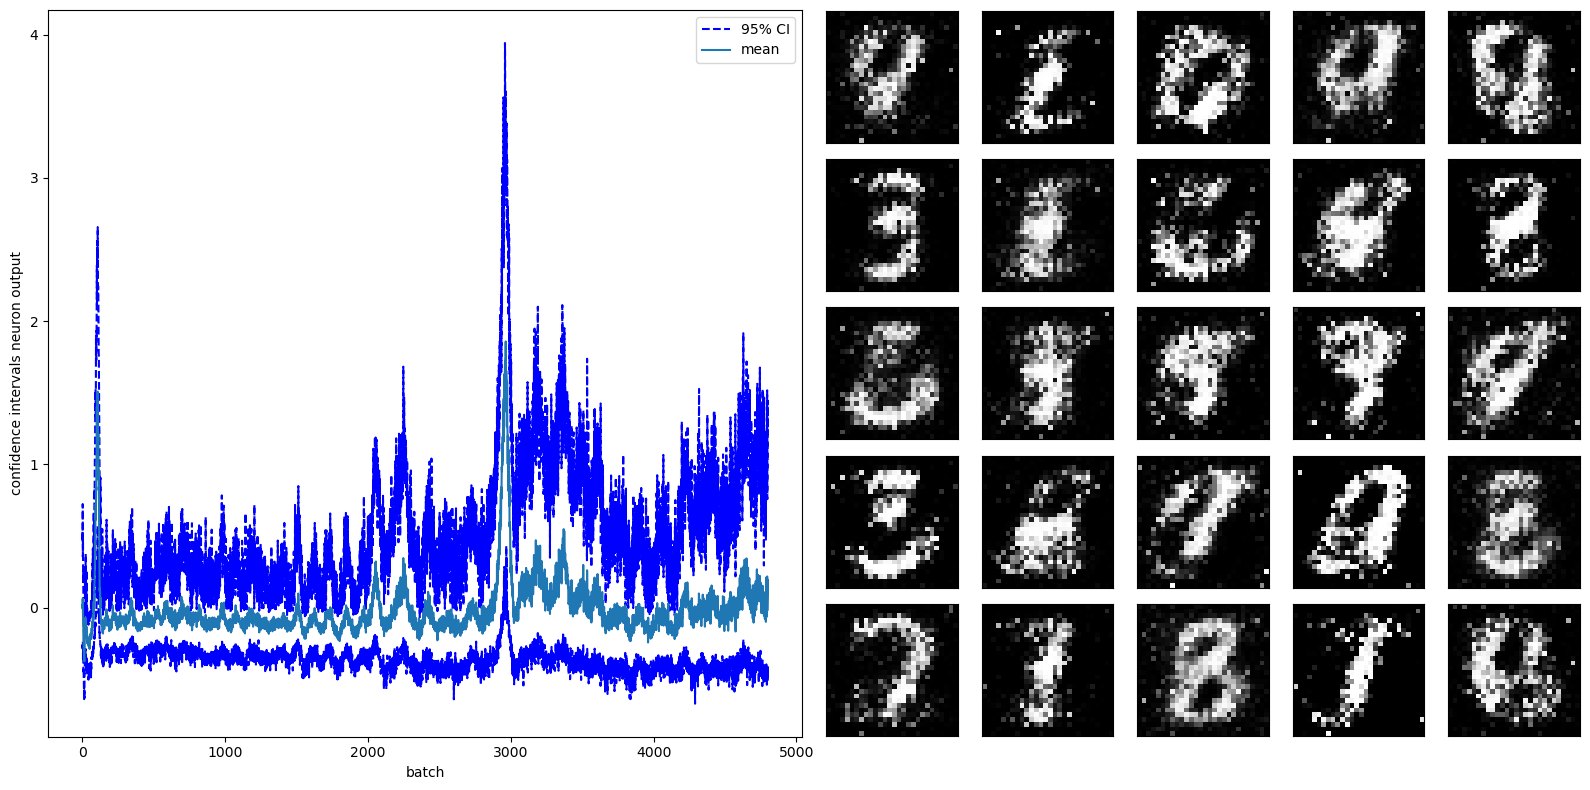

In [18]:
%matplotlib inline
# select to run for n_epochs epochs
# n_batch = n_iter
# manually specify the number of mini-batch iterations
n_batch = 5000
fig = plt.figure(figsize=[16,8])
train(n_batch, batch_size, G, D, X_train, n_draw = 200)

Finally, below we will repeat the exact same experiment, except with `batch_norm=True`. Although some variation can still take place, the distribution of the selected neuron should look more constant over the training batches compared to the case without batch normalization.

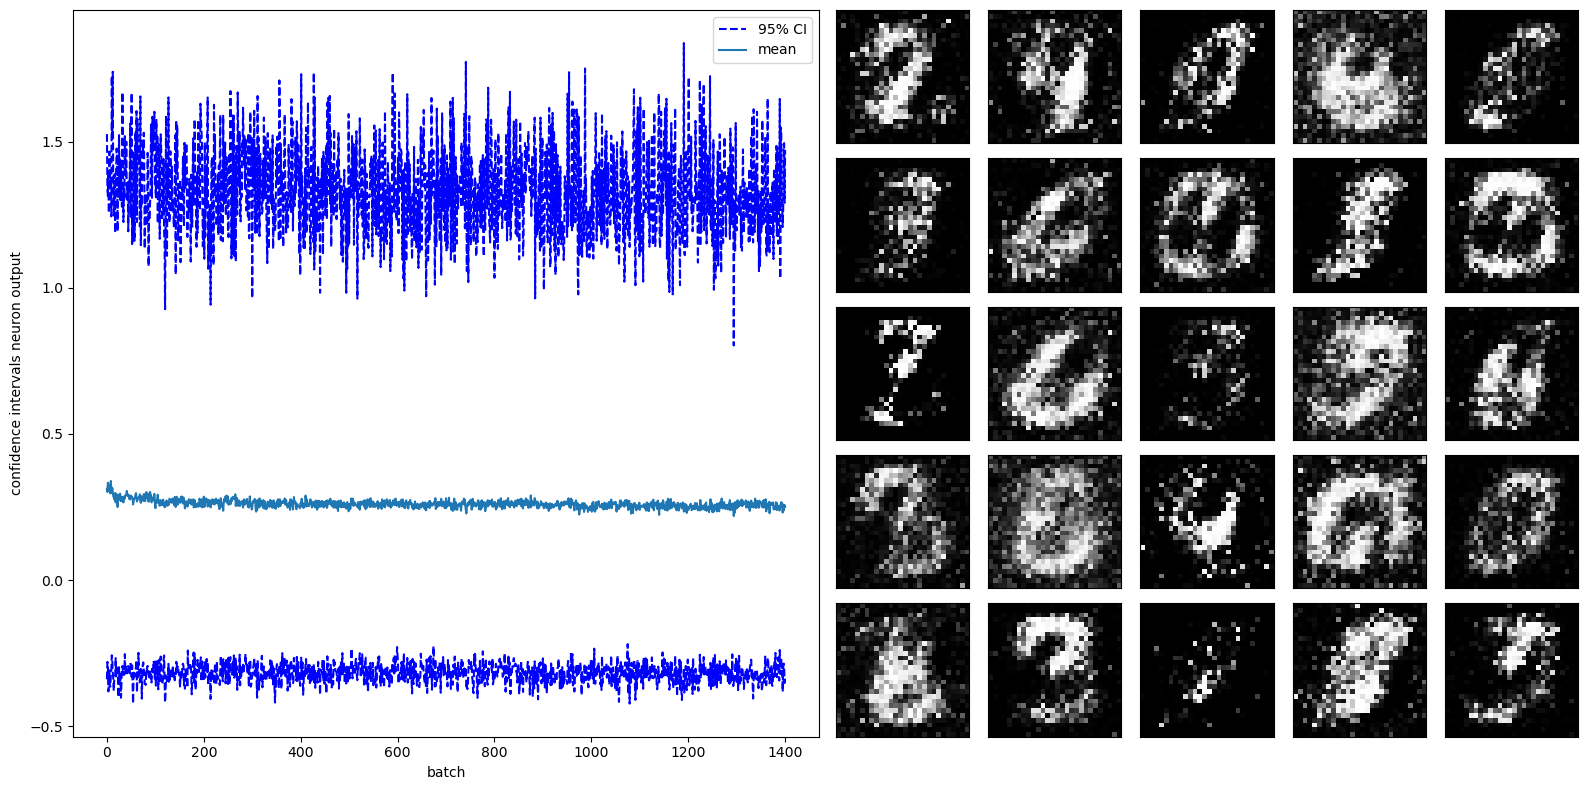

 32%|████████████████████████████████████████████████████                                                                                                               | 1598/5000 [01:30<02:18, 24.59it/s]

In [ ]:
G = define_generator(n_layers = 3, 
                     n_neurons = [256, 512, 1024], 
                     n_out = n_out,
                     n_latent = n_latent,
                     batch_size = batch_size,
                     batch_norm=True)

D = define_discriminator(X_train, 
                         n_layers = 2,
                         n_neurons = [512, 256],
                         batch_size = batch_size)

G.layers[-1].layer_rp1 = D.layers[0]

activation_G = []

fig = plt.figure(figsize=[16,8])
train(n_batch, batch_size, G, D, X_train, n_draw = 200)

If you want to inspect the $\gamma_2^{(i)}$ values of all neurons in the 2nd hidden layer (usually around 1), execute:

In [ ]:
G.layers[2].bn.gamma

If you want to inspect the $\beta_2^{(i)}$ values of all neurons in the 2nd hidden layer (usually around 0), execute:

In [ ]:
G.layers[2].bn.beta